In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bibekchalise","key":"b6bd41f3636f0e308309be1cec0afa00"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:18<00:00, 140MB/s]
100% 2.70G/2.70G [00:18<00:00, 153MB/s]


In [6]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [17]:
#import of the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

In [9]:
plants = ['Apple', 'Maize', 'Potato']

In [12]:
diseases = []

In [13]:
trn_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
for i in os.listdir(trn_path):
  if i.split('__')[0] == 'Apple':
    diseases.append(i)

In [14]:
diseases

['Apple___Black_rot',
 'Apple___Apple_scab',
 'Apple___healthy',
 'Apple___Cedar_apple_rust']

In [20]:
path = []
labels  = []
for dis in diseases:
  for i in os.listdir(os.path.join(trn_path, dis)):
    path.append(trn_path+'/'+dis+'/'+i)
    labels.append(dis)
df = pd.DataFrame(zip(path, labels)) 

In [24]:
df.columns = ['path', 'label']

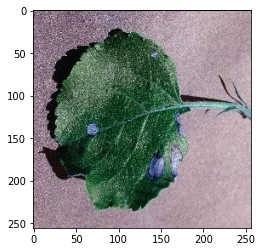

In [25]:
plt.imshow(cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/34eb19d8-32a9-4c9b-829f-d0ed705c5f03___JR_FrgE.S 3064_90deg.JPG'))

In [32]:
valid_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [33]:
for i in os.listdir(valid_path):
  if i.split('__')[0] == 'Apple':
    diseases.append(i)

In [34]:
path = []
labels  = []
for dis in diseases:
  for i in os.listdir(os.path.join(valid_path, dis)):
    path.append(valid_path+'/'+dis+'/'+i)
    labels.append(dis)
df_test = pd.DataFrame(zip(path, labels)) 

In [36]:
df_test.columns = ['path', 'label']

In [37]:
df_test.head()

,path,label
0,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
1,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
2,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
3,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
4,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot


In [26]:
df.head()

,path,label
0,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
1,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
2,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
3,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot
4,/content/New Plant Diseases Dataset(Augmented)...,Apple___Black_rot


In [28]:
df.label.value_counts()

Apple___Apple_scab          2016
Apple___healthy             2008
Apple___Black_rot           1987
Apple___Cedar_apple_rust    1760
Name: label, dtype: int64

In [30]:
#import pytorch libraries
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torchvision.models import vgg16
from sklearn.model_selection import train_test_split
import torch.nn.functional as Fun

In [38]:
lb = LabelEncoder()
df_test.label =  lb.fit_transform(df_test.label)
df.label =  lb.fit_transform(df.label)
dict(zip(lb.classes_, lb.transform(lb.classes_)))

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [39]:
apple_classes = {'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [41]:
class AppleDataset(Dataset):
    def __init__(self, df):
        self.fpath = df.path
        self.label = df.label
        self.transforms = T.Compose(
        [
        T.Normalize(mean=[0.485,
           0.456, 0.406],std=[0.229, 0.224, 0.225])]
        )
    def __len__(self):
        return len(self.fpath)
    
    def __getitem__(self,ix):
        f = self.fpath[ix]
        label = self.label[ix]
        im = cv2.imread(f)
        im = cv2.resize(im, (224,224))
        # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = self.transforms(im)
        im = ((im - 127.5) / 127.5)
        return torch.tensor(im,dtype=torch.float).to(device), torch.tensor(label, dtype=torch.float).long().to(device)
        

In [42]:
def get_model():
    model = torchvision.models.vgg16(pretrained=True)
    for param in model.features.parameters():
                   param.requires_grad = False
    model.avgpool = model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128, 4),
                                   nn.Softmax())
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [43]:
model, loss_fn, optimizer = get_model()
from torchsummary import summary

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [44]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
def get_data():
    train = AppleDataset(df)
    test = AppleDataset(df_test)
    trn_dl = DataLoader(train, batch_size=16,shuffle=True, drop_last=True)
    test_dl = DataLoader(test, batch_size=16, shuffle=True, drop_last=True)
    return trn_dl, test_dl

In [46]:
def train_batch(x, y, model, loss_fn, opt):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [47]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    pred = model(x)
    _, is_correct = torch.max(pred.data,1)
    acc_all = (is_correct==y).detach().cpu().numpy()
    return acc_all

In [48]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [50]:
trn_ldr, test_ldr = get_data()


In [ ]:
train_loss = []
train_accuracies= []
val_loss = [] 
val_accuracies = []

for i in range(20):
    print(f'Epoch: _________*****{i}*****_______')
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies, val_epoch_losses = [], []



    for ix, batch in (enumerate(iter(trn_ldr))):
        
        x, y = batch
        # x = x.permute(0, 3,1,2)
        train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



    for ix, batch in (enumerate(iter(trn_ldr))):
        x, y = batch
        # x = x.permute(0, 3,1,2)
        train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
    train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
    print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')


    for ix, batch in (enumerate(iter(test_ldr))):
        x, y = batch
        # x = x.permute(0, 3,1,2)
        val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
    val_epoch_loss = np.array(val_epoch_losses).mean()
    print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

    for ix, batch in (enumerate(iter(test_ldr))):
        x, y = batch
        # x = x.permute(0, 3,1,2)
        val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
    val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
    print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
    print('\n')

    train_loss.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    val_loss.append(val_epoch_loss)